In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
SEED = 23

In [43]:
def train_and_evaluate(clf, X_train, y_train, X_test, y_test, suffix=''):
    # Fit the classifier
    clf.fit(X_train, y_train)
    
    # Predict values
    globals()[f'y_pred_train{suffix}'] = clf.predict(X_train)
    globals()[f'y_pred{suffix}'] = clf.predict(X_test)
    
    # Predict probabilities
    globals()[f'y_probs{suffix}'] = clf.predict_proba(X_test)[:, 1]

    # Calculate metrics
    globals()[f'train_score{suffix}'] = clf.score(X_train, y_train)
    globals()[f'test_score{suffix}'] = clf.score(X_test, y_test)
    globals()[f'f1_score{suffix}'] = f1_score(y_test, globals()[f'y_pred{suffix}'])
    
    # Print results
    print(f'Train score{suffix}:', globals()[f'train_score{suffix}'])
    print(f'Test score{suffix}:', globals()[f'test_score{suffix}'])
    print(f'F1-score{suffix}:', globals()[f'f1_score{suffix}'])

In [44]:
def Standard_Outlier_Remover(df_source, num_cols, num_std=3): 
    """
    Remove outliers from specified numeric columns in a DataFrame.
    
    Parameters:
    -----------
    df_source : pandas DataFrame
        The original DataFrame from which to remove outliers.
    num_cols : list of str
        List of column names in df_source that are numeric and should be checked for outliers.
    num_std : int or float, optional
        The number of standard deviations to use for defining outliers. Default is 3.
        
    Returns:
    --------
    df_win : pandas DataFrame
        A new DataFrame with outliers removed.
    ratio : float
        The percentage of observations in the original DataFrame that were identified as outliers.
    outliers : list of int
        List of row indices in the original DataFrame that were identified as outliers.
    """
    
    df = df_source.copy()
    
    outliers = []
    
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        tol = num_std * std
        upper = mean + tol
        lower = mean - tol
        
        # Using vectorized operations to find outliers
        outlier_mask = (df[col] > upper) | (df[col] < lower)
        outliers.extend(df.index[outlier_mask])
        
    # Remove duplicates
    outliers = list(set(outliers))
    
    # Calculate ratio of outliers
    ratio = round(len(outliers) / len(df) * 100, 2)
    
    # Drop outliers
    df_win = df.drop(index=outliers)
    
    return df_win, ratio, outliers

In [45]:
def high_corr(df_source, method='spearman', thsld=0.8, perc=0.95):
    """
    Remove columns from a DataFrame that are highly correlated with other columns.

    Parameters:
    -----------
    df_source : pandas.DataFrame
        The original DataFrame for which to identify and remove highly correlated columns.

    method : str, optional
        The correlation method to be used. 'pearson', 'kendall', 'spearman' are supported. 
        Default is 'spearman'.

    thsld : float, optional
        The absolute correlation threshold. Pairs of columns with correlation higher than this value 
        will be considered for removal. Default is 0.8.

    perc : float, optional
        The percentile to use for deciding which variable to remove from a highly correlated pair.
        Should be between 0 and 1. Default is 0.95.

    Returns:
    --------
    df : pandas.DataFrame
        A new DataFrame with highly correlated columns removed.

    Notes:
    ------
    - For each pair of highly correlated columns, the function removes the one with the higher
      percentile value of correlation, based on the 'perc' parameter.
    - Prints out the columns that are removed and their percentile values.

    Example:
    --------
    >>> high_corr(df)
    Removing A with 0.95th percentile = 1.0
    Remaining columns: Index(['B', 'C'], dtype='object')
    """
    df =  df_source.copy()
    corr = df.corr(method)
    high_corr_vars = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > thsld:
                colname_i = corr.columns[i]
                colname_j = corr.columns[j]

                # Calculate mean correlation for each variable
                perc_i = np.percentile(corr[colname_i], perc)
                perc_j = np.percentile(corr[colname_j], perc)

                # Decide which variable to remove from each correlated pair based on its highest percentile value in the correlation matrix.
                max_abs_value = max(abs(perc_i), abs(perc_j))
                if max_abs_value >= thsld:
                    if abs(perc_i) > abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))
                else:
                    if abs(perc_i) <= abs(perc_j):
                        high_corr_vars.append((colname_i, perc_i))
                    else:
                        high_corr_vars.append((colname_j, perc_j))

                    

    # Remove the variable with the highest mean correlation from each pair
    for var, perc_val in high_corr_vars:
        if var in df.columns:
            print(f"Removing {var} with {perc}th percentile = {perc_val}")
            del df[var]

    print("Remaining columns:", df.columns)
    return df

In [57]:
def feature_importance_logreg(logistic_model, cut_off=None):
    """
    Plots feature importances for a logistic regression model using L1 regularisation.

    Parameters:
    ----------
    logistic_model : sklearn.linear_model object
        The logistic regression model.

    cut_off : float, optional
        The cut-off value to consider for feature importance.

    Returns:
    -------
    feature_df : pandas DataFrame
        A DataFrame containing the features sorted by their importance.
        
    omitted_df : pandas DataFrame
        A DataFrame containing the features that were omitted based on the cut-off value.
    """
    # Get feature importances
    feature_importance_values = np.abs(logistic_model.coef_)
    
    # Sort feature importances
    indices = np.argsort(feature_importance_values[0])[::-1]
    
    sorted_feature_names = [X_train.columns[i] for i in indices]
    sorted_importance_values = [feature_importance_values[0][i] for i in indices]
    
    # Apply cutoff if specified
    if cut_off is not None:
        omitted_feature_names = [name for i, name in enumerate(sorted_feature_names) if sorted_importance_values[i] < cut_off]
        omitted_importance_values = [value for value in sorted_importance_values if value < cut_off]
        
        sorted_feature_names = [name for name in sorted_feature_names if name not in omitted_feature_names]
        sorted_importance_values = [value for value in sorted_importance_values if value >= cut_off]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance (Logistic Regression)")
    plt.bar(range(len(sorted_importance_values)), sorted_importance_values, align="center")
    plt.xticks(range(len(sorted_importance_values)), sorted_feature_names, rotation=90)  # Add rotation for better visibility
    plt.xlabel("Feature Name")
    plt.ylabel("Absolute Coefficient Value")
    plt.show()
    
    # Create a DataFrame for sorted feature importances
    feature_df = pd.DataFrame({
        'Feature': sorted_feature_names,
        'Importance': sorted_importance_values
    })
    
    # Create a DataFrame for omitted feature importances
    omitted_df = pd.DataFrame({
        'Omitted Feature': omitted_feature_names,
        'Omitted Importance': omitted_importance_values
    })
    
    return feature_df, omitted_df

In [60]:
def feature_importance_logreg(logistic_model, X_train, y_train, cut_off=None):
    """
    Plots feature importances for a logistic regression model using L1 regularisation.

    Parameters:
    ----------
    logistic_model : sklearn.linear_model object
        The logistic regression model. 
    X_train : array-like or DataFrame
        The features for the training set.
    y_train : array-like or DataFrame
        The target variable for the training set. 
    cut_off : float, optional
        The cut-off value to consider for feature importance.

    Returns:
    -------
    feature_df : pandas DataFrame
        A DataFrame containing the features sorted by their importance.
        
    omitted_df : pandas DataFrame
        A DataFrame containing the features that were omitted based on the cut-off value.
    """
    # Create the model
    logistic_model.fit(X_train, y_train)
    
    # Get feature importances
    feature_importance_values = np.abs(logistic_model.coef_)
    
    # Sort feature importances
    indices = np.argsort(feature_importance_values[0])[::-1]
    
    sorted_feature_names = [X_train.columns[i] for i in indices]
    sorted_importance_values = [feature_importance_values[0][i] for i in indices]
    
    # Apply cutoff if specified
    if cut_off is not None:
        omitted_feature_names = [name for i, name in enumerate(sorted_feature_names) if sorted_importance_values[i] < cut_off]
        omitted_importance_values = [value for value in sorted_importance_values if value < cut_off]
        
        sorted_feature_names = [name for name in sorted_feature_names if name not in omitted_feature_names]
        sorted_importance_values = [value for value in sorted_importance_values if value >= cut_off]
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(sorted_importance_values)), sorted_importance_values, align="center")
    plt.xticks(range(len(sorted_importance_values)), sorted_feature_names, rotation=90)  # Add rotation for better visibility
    plt.xlabel("Feature Name")
    plt.ylabel("Absolute Coefficient Value")
    plt.show()
    
    # Create a DataFrame for sorted feature importances
    feature_df = pd.DataFrame({
        'Feature': sorted_feature_names,
        'Importance': sorted_importance_values
    })
    
    # Create a DataFrame for omitted feature importances
    omitted_df = pd.DataFrame({
        'Omitted Feature': omitted_feature_names,
        'Omitted Importance': omitted_importance_values
    })
    
    return feature_df, omitted_df

In [73]:
def plot_omitted_accuracy(X_train_smote, y_train_smote, X_test_final, y_test, high_pvalues, low_imp_df, SEED=42):
    """
    Plots the train and test accuracy of a Logistic Regression model when omitting certain variables.
    Performs this operation with and without replacement.

    Parameters:
    -----------
    X_train_smote, y_train_smote : Training data and labels
    X_test_final, y_test : Test data and labels
    high_pvalues : list of features to be omitted based on high p-values
    low_imp_df : DataFrame containing features to be omitted based on low importance
    SEED : random state seed for reproducibility

    Returns:
    --------
    acc_df : DataFrame containing train and test accuracies

    """
    fig, axs = plt.subplots(1, 2, figsize=(24, 6))

    # Omitting variables with replacement
    to_delete = set(high_pvalues + low_imp_df['Omitted Feature'].to_list())
    acc_dict = {}
    for var in to_delete:
        X_train_fe = X_train_smote.copy()
        X_train_fe.drop(columns=var, inplace=True)
        log = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=1000, random_state=SEED)
        log.fit(X_train_fe, y_train_smote)
        train_score = log.score(X_train_fe, y_train_smote)
        y_pred_fe = log.predict(X_test_final[X_train_fe.columns])
        test_score = accuracy_score(y_pred_fe, y_test)
        acc_dict[var] = [train_score, test_score]
    acc_df = pd.DataFrame(acc_dict).transpose()
    acc_df.columns = ['train_acc', 'test_acc']
    acc_df.plot(ax=axs[0], title='With Replacement')
    axs[0].set_xticks(np.arange(len(acc_df.index)))
    axs[0].set_xticklabels(acc_df.index, rotation=90)

    # Omitting variables without replacement
    to_delete = list(acc_df.sort_values('test_acc', ascending=False).index)
    acc_dict = {}
    X_train_fe = X_train_smote.copy()
    for var in to_delete:
        X_train_fe.drop(columns=var, inplace=True)
        log = LogisticRegression(max_iter=1000, random_state=SEED)
        log.fit(X_train_fe, y_train_smote)
        train_score = log.score(X_train_fe, y_train_smote)
        y_pred_fe = log.predict(X_test_final[X_train_fe.columns])
        test_score = accuracy_score(y_pred_fe, y_test)
        acc_dict[var] = [train_score, test_score]
    acc_df = pd.DataFrame(acc_dict).transpose()
    acc_df.columns = ['train_acc', 'test_acc']
    acc_df.plot(ax=axs[1], title='Without Replacement')
    axs[1].set_xticks(np.arange(len(acc_df.index)))
    axs[1].set_xticklabels(acc_df.index, rotation=90)
    plt.show()
    
    #Creating the list of omitted variables
    acc_delete = []
    for var in acc_df.index:
        acc_delete.append(var)
        if acc_df['test_acc'].idxmax() in acc_delete:
            break

    return acc_df, acc_delete

# Data generation

In [46]:
# Create synthetic dataset
X, y = make_classification(n_samples=10000, 
                           n_features=20,
                           n_informative = 12,
                           n_redundant = 3,
                           n_repeated = 5,
                           n_classes = 2,
                           scale = 10000,
                           random_state=SEED)
df = pd.DataFrame(X) 
df['y'] = y

display(df.drop(columns ='y').describe())
display(df['y'].value_counts(normalize = True))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5155.901801,-4969.616471,-153.035379,4620.549097,5139.254619,-183.120881,110.830666,-5034.714979,3234.695074,5155.901801,-268.327464,-33.408081,-195.584992,-10631.788424,110.830666,-5104.748296,7269.983119,3234.695074,-195.584992,4620.549097
std,21654.867014,20155.071402,20352.301513,49515.069729,20504.204672,22484.909309,22537.807139,23800.213261,49579.119100,21654.867014,21663.119421,23900.597072,23232.494264,20276.274292,22537.807139,22868.217511,45642.460001,49579.119100,23232.494264,49515.069729
min,-71950.997455,-77878.476181,-84691.611676,-190870.531555,-76111.778303,-78930.329440,-90420.847256,-92746.559845,-191449.753858,-71950.997455,-82126.705182,-85096.643789,-98361.780171,-83891.135744,-90420.847256,-99366.197135,-173753.604283,-191449.753858,-98361.780171,-190870.531555
25%,-9532.697988,-18532.966084,-13322.211109,-28837.781818,-9274.215456,-15471.461139,-14064.098783,-20818.404649,-30329.509577,-9532.697988,-14838.849401,-16270.681370,-15635.211553,-24384.620024,-14064.098783,-20405.101616,-22400.542426,-30329.509577,-15635.211553,-28837.781818
50%,5379.429223,-6126.002335,1302.651433,6286.207153,4216.026377,-156.804357,1943.674010,-5501.985952,1961.969218,5379.429223,23.322457,-196.279435,319.836156,-10779.653535,1943.674010,-4751.190472,8420.971565,1961.969218,319.836156,6286.207153
75%,19780.080533,7120.328032,14234.711916,38564.258180,18474.547946,14995.843229,15714.702111,10580.813963,35822.594407,19780.080533,14594.873395,16023.255682,15627.108999,3225.550618,15714.702111,10564.633550,38061.152227,35822.594407,15627.108999,38564.258180
max,87260.189569,91867.643298,67943.271390,235489.809816,85832.459795,90378.383086,75217.101982,96037.418819,225077.640912,87260.189569,91699.430370,88049.039337,78658.074669,71826.388332,75217.101982,76270.909676,165796.105191,225077.640912,78658.074669,235489.809816


y
1    0.5011
0    0.4989
Name: proportion, dtype: float64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns ='y') ,df['y'], test_size=0.2, random_state=SEED)

# Basic model

In [48]:
# Create and fit logistic regression model
clf = LogisticRegression(random_state = SEED)
clf.fit(X_train, y_train)

# Predict values
y_pred = clf.predict(X_test)

# Predict probabilities
y_probs = clf.predict_proba(X_test)[:, 1]

train_score_base = clf.score(X_train, y_train)
test_score_base = clf.score(X_test, y_test)

print('Train score: ', train_score_base)
print('Test score: ', test_score_base)

Train score:  0.7745
Test score:  0.7675


In [49]:
train_and_evaluate(clf, X_train, y_train, X_test, y_test, suffix='_base')

Train score_base: 0.7745
Test score_base: 0.7675
F1-score_base: 0.7732813261823501


# Model without outliers

In [50]:
df_cut, ratio, outliers = Standard_Outlier_Remover(df, df.drop(columns ='y').columns, num_std=3)
X_train_cut, X_test_cut, y_train_cut, y_test_cut = train_test_split(df_cut.drop(columns ='y') ,df_cut['y'], test_size=0.2, random_state=SEED)

train_and_evaluate(clf, X_train_cut, y_train_cut, X_test_cut, y_test_cut, suffix='_cut')

Train score_cut: 0.77614871056421
Test score_cut: 0.768586387434555
F1-score_cut: 0.7744897959183674


# Model without multicollinearity

In [51]:
df_corr = high_corr(df, method='spearman', thsld=0.8, perc=0.95)
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(df_corr.drop(columns ='y') ,df_corr['y'], test_size=0.2, random_state=SEED)

train_and_evaluate(clf, X_train_corr, y_train_corr, X_test_corr, y_test_corr, suffix='_corr')

Removing 9 with 0.95th percentile = -0.21467404622202046
Removing 14 with 0.95th percentile = -0.6405212192852122
Removing 17 with 0.95th percentile = -0.5309541407495014
Removing 18 with 0.95th percentile = -0.10731633362256333
Removing 19 with 0.95th percentile = -0.6405212192852122
Remaining columns: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 'y'], dtype='object')
Train score_corr: 0.7745
Test score_corr: 0.7675
F1-score_corr: 0.7732813261823501


# Model with Scaling

In [52]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

train_and_evaluate(clf, X_train_std, y_train, X_test_std, y_test, suffix='_std')

Train score_std: 0.776
Test score_std: 0.7685
F1-score_std: 0.7709054923305294


# Model with Scaling and without multicollinearity

In [53]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_corr)
X_test_std = scaler.transform(X_test_corr)

train_and_evaluate(clf, X_train_std, y_train, X_test_std, y_test, suffix='_std_corr')

Train score_std_corr: 0.776
Test score_std_corr: 0.7685
F1-score_std_corr: 0.7709054923305294


# Model with Scaling and without multicollinearity and outliers

In [54]:
df_corr_cut = high_corr(df_cut, method='spearman', thsld=0.8, perc=0.95)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_corr_cut.drop(columns ='y') ,df_corr_cut['y'], test_size=0.2, random_state=SEED)

train_and_evaluate(clf, X_train_all, y_train_all, X_test_all, y_test_all, suffix='_all')

Removing 9 with 0.95th percentile = -0.21649248366621973
Removing 14 with 0.95th percentile = -0.6396877972338405
Removing 17 with 0.95th percentile = -0.53031644121697
Removing 18 with 0.95th percentile = -0.11713223188237455
Removing 19 with 0.95th percentile = -0.6396877972338405
Remaining columns: Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 'y'], dtype='object')
Train score_all: 0.77614871056421
Test score_all: 0.768586387434555
F1-score_all: 0.7744897959183674


In [55]:
train_score = [train_score_base, train_score_cut, train_score_corr, train_score_std, train_score_std_corr, train_score_all]

In [56]:
train_score

[0.7745, 0.77614871056421, 0.7745, 0.776, 0.776, 0.77614871056421]

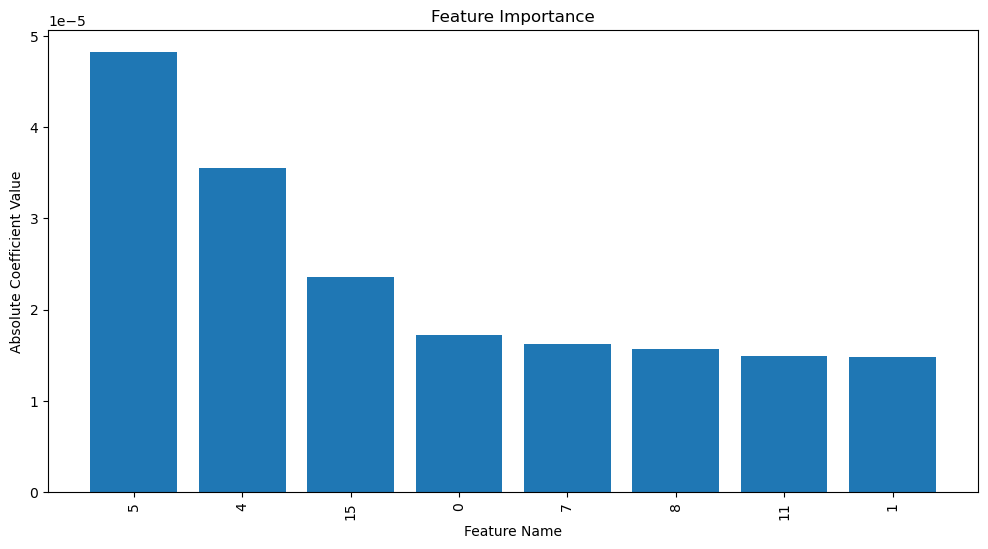

In [69]:
feature_df, low_imp_df = feature_importance_logreg(clf, X_train_all, y_train_all, cut_off = 0.00001)

In [72]:
low_imp_df

,Omitted Feature,Omitted Importance
0,12,9.035262e-06
1,10,4.311684e-06
2,3,4.081559e-06
3,6,3.663302e-06
4,16,1.560027e-06
5,2,1.000459e-06
6,13,7.741303e-07


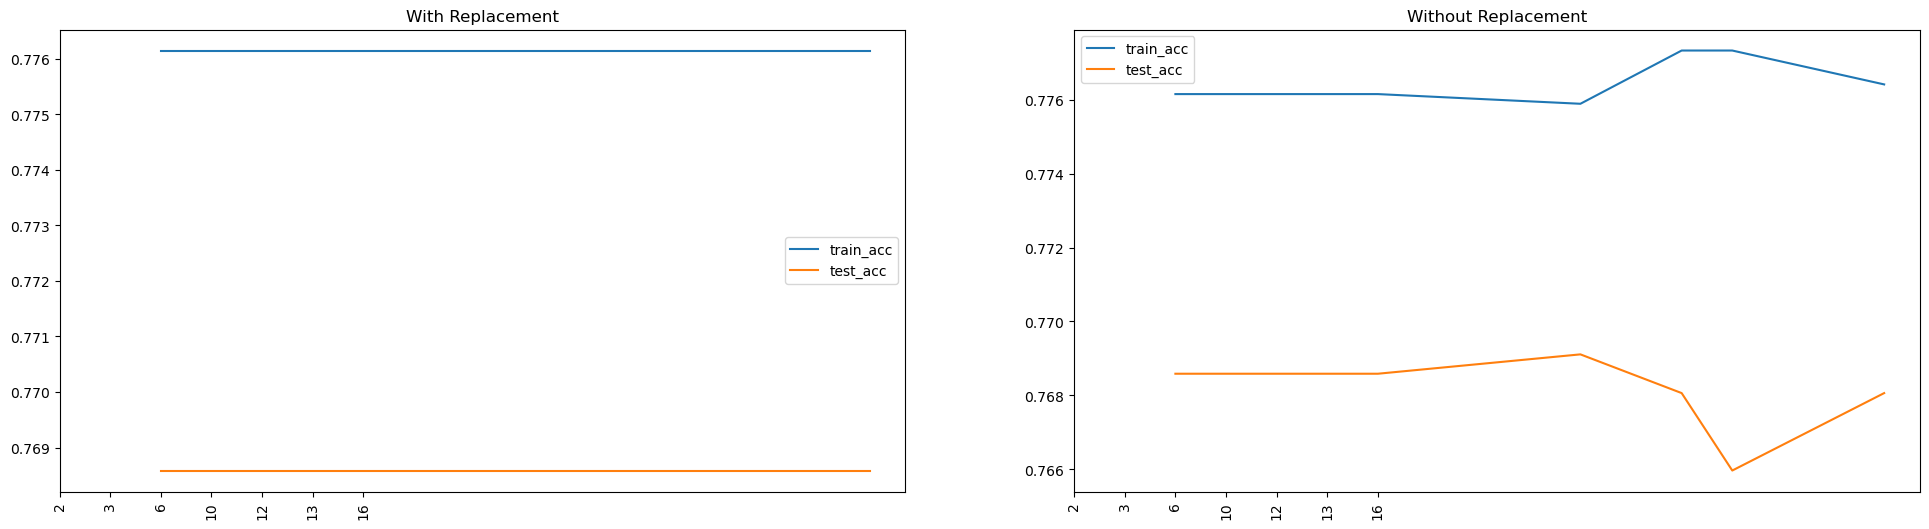

(    train_acc  test_acc
 2    0.776149  0.768586
 3    0.776149  0.768586
 6    0.776149  0.768586
 10   0.775887  0.769110
 12   0.777327  0.768063
 13   0.777327  0.765969
 16   0.776411  0.768063,
 [2, 3, 6, 10])

In [77]:
plot_omitted_accuracy(X_train_all, y_train_all, X_test_all, y_test_all, [], low_imp_df, SEED=SEED)